In [2]:
# Imports
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Hyperparams
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02 #default = 0.02
STYLE_WEIGHT = 0 #default = 4.5
STYLE_WEIGHT2 = 4
TOTAL_VARIATION_WEIGHT = 0.995 #default = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25 #default = 1.25


In [0]:
# Paths
input_image_path = "drive/My Drive/AIschool Team4/장지선/input.png"
style_image_path = "drive/My Drive/AIschool Team4/장지선/style.png"
style_image_path2 = "drive/My Drive/AIschool Team4/장지선/style2.png"
output_image_path = "drive/My Drive/AIschool Team4/장지선/output.png"
combined_image_path = "drive/My Drive/AIschool Team4/장지선/combined.png"

# San Francisco
san_francisco_image_path = "drive/My Drive/AIschool Team4/장지선/pic_1900.jpg"

# Warsaw by Tytus Brzozowski, http://t-b.pl
# tytus_image_path = "http://meetingbenches.com/wp-content/flagallery/tytus-brzozowski-polish-architect-and-watercolorist-a-fairy-tale-in-warsaw/tytus_brzozowski_13.jpg"
tytus_image_path = "http://image.chosun.com/sitedata/image/201406/27/2014062704891_0.jpg"
tytus_image_path2 = "drive/My Drive/AIschool Team4/장지선/bridge.png"

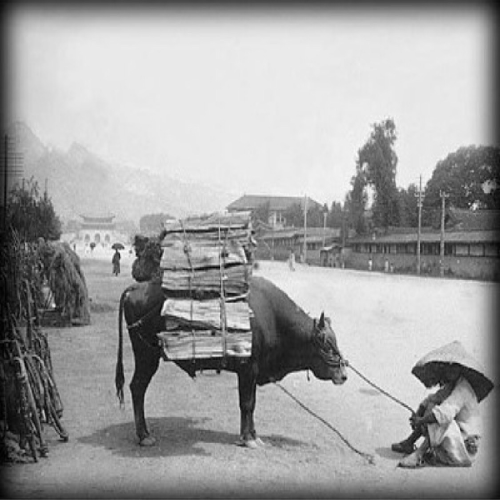

In [6]:
#Input visualization 
# input_image = Image.open(BytesIO(requests.get(san_francisco_image_path).content))
input_image = Image.open(san_francisco_image_path)
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

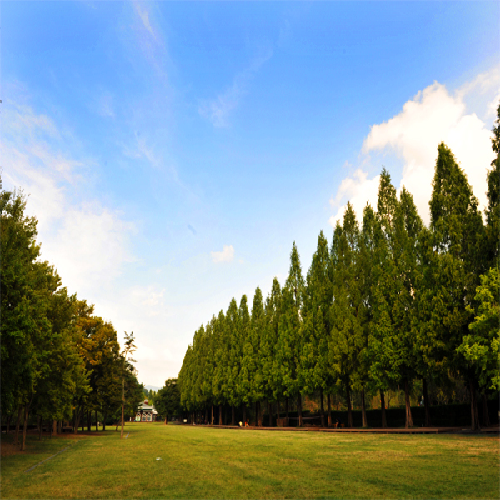

In [7]:
# Style visualization 
style_image = Image.open(BytesIO(requests.get(tytus_image_path).content))
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

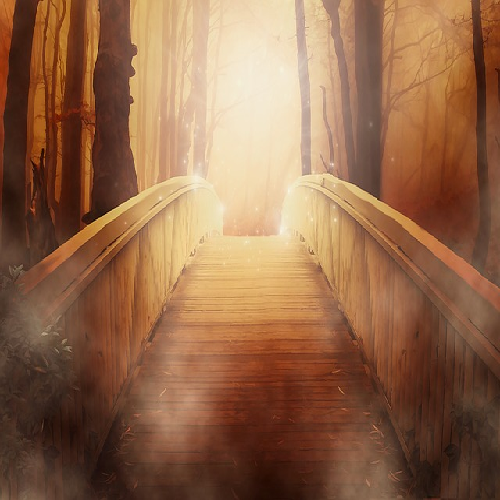

In [8]:
# Style visualization2
# style_image2 = Image.open(BytesIO(requests.get(tytus_image_path2).content))
style_image2 = Image.open(tytus_image_path2)
style_image2 = style_image2.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image2.save(style_image_path2)
style_image2

In [0]:
# Data normalization and reshaping from RGB to BGR
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

style_image_array2 = np.asarray(style_image2, dtype="float32")
style_image_array2 = np.expand_dims(style_image_array2, axis=0)
style_image_array2[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array2[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array2[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array2 = style_image_array[:, :, :, ::-1]

In [10]:
# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
style_image2 = backend.variable(style_image_array2)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image,style_image2], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

W0815 15:18:00.303852 140172237395840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 15:18:00.312965 140172237395840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 15:18:00.315207 140172237395840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 15:18:00.360373 140172237395840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0815 15:18:01.473269 140172237395840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0815 15:18:01.474578 140172237395840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [11]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

content_layer = 'block2_conv2'
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss = loss + CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

{'input_1': <tf.Tensor 'concat:0' shape=(4, 500, 500, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(4, 500, 500, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(4, 500, 500, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(4, 250, 250, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(4, 250, 250, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(4, 250, 250, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(4, 125, 125, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(4, 125, 125, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(4, 125, 125, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(4, 125, 125, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(4, 62, 62, 256) dtype=float32>, 'block4_conv1': <tf.Tensor 'b

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss = loss + (STYLE_WEIGHT / len(style_layers)) * style_loss
    
# style_layers2 = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features2 = layer_features[3, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss2 = compute_style_loss(style_features2, combination_features)
    loss = loss + (STYLE_WEIGHT2 / len(style_layers)) * style_loss2
    

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [15]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])    
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()


W0815 15:18:05.580675 140172237395840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iteration 0 completed with loss 107473780736
Iteration 1 completed with loss 72474296320
Iteration 2 completed with loss 42099482624
Iteration 3 completed with loss 26481752064
Iteration 4 completed with loss 20420630528
Iteration 5 completed with loss 17214066688
Iteration 6 completed with loss 15336881152
Iteration 7 completed with loss 14244171776
Iteration 8 completed with loss 13624581120
Iteration 9 completed with loss 13232012288


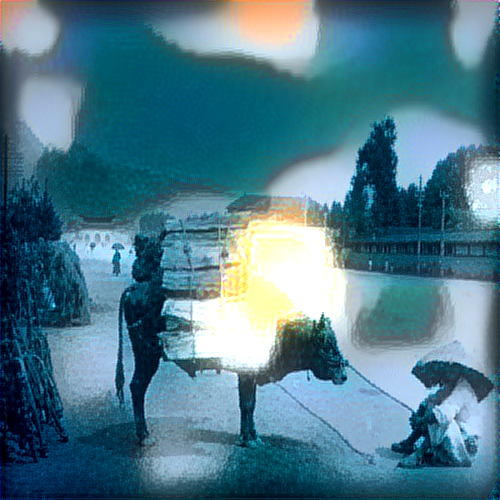

In [16]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

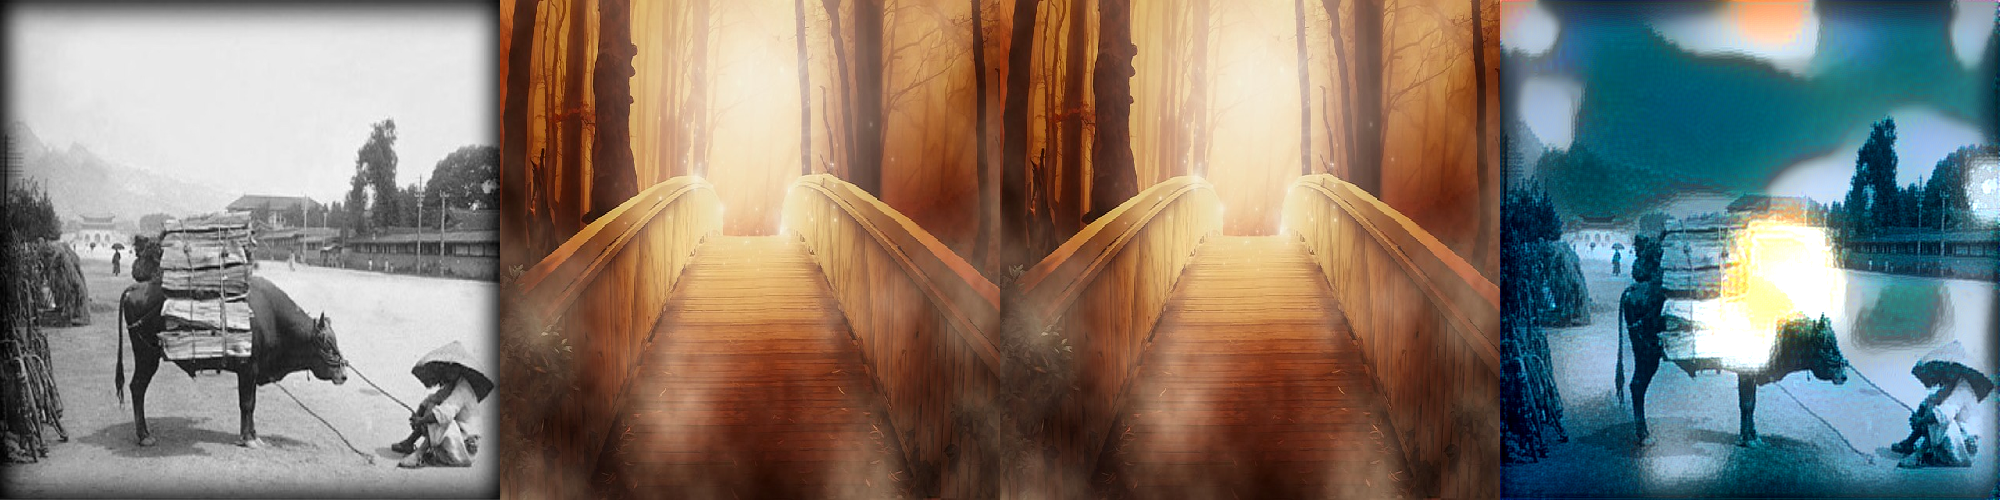

In [17]:
# Visualizing combined results
combined = Image.new("RGB", (IMAGE_WIDTH*4, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, style_image_path2, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined